# US Adult Income

## Purpose of the project

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
...
</div>

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.metrics import (accuracy_score, classification_report)
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam

from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent

import tensorflow as tf

from art import config
from art.estimators.classification import KerasClassifier, TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod, ZooAttack, ProjectedGradientDescent
from art.attacks.evasion import BasicIterativeMethod, DeepFool, CarliniLInfMethod
from art.defences.trainer import AdversarialTrainer

import numpy as np

import matplotlib.pyplot as plt

from sklearn.utils import shuffle

c:\Users\ol200\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Table of Contents

- [1. Dataset](#dataset) 
    - [a. Description](#description) 
    - [b. Data cleaning](#data-cleaning)
- [2. Attack-Defense](#attack--defense)
    - [a. Attack](#attack) 
    - [b. Defense](#defense)

## Dataset

### Description

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

The US Adult Income dataset, sourced from [Kaggle](https://www.kaggle.com/datasets/johnolafenwa/us-census-data), was originally extracted by Barry Becker from the 1994 US Census Database. It contains anonymous data about various social and economic factors, including occupation, age, native country, race, capital gain, capital loss, education, work class, and more.

Each entry in the dataset is labeled based on income, categorizing individuals as earning either ">50K" or "<=50K" annually. This classification allows for the analysis of how different social factors correlate with income levels.

The dataset is divided into two CSV files:
* `adult-training.txt`: Contains data used for training models.
* `adult-test.txt`: Contains data used for testing models.

This dataset is commonly utilized for machine learning tasks focused on income prediction and social factor analysis.
</div>

### Data cleaning

##### Read data

In [2]:
# Define path to data files
train_file = "data/adult-training.csv"
test_file = "data/adult-test.csv"

In [3]:
# Define columns
COLUMNS = ["age", "workclass", "fnlwgt", "education","education_num",
           "marital_status", "occupation", "relationship", "race", "gender",
           "capital_gain", "capital_loss", "hours_per_week", "native_country", "income_bracket"]

In [4]:
# Read data into df
df_train = pd.read_csv(train_file, names = COLUMNS, skipinitialspace = True, engine= "python")
df_test = pd.read_csv(test_file, names = COLUMNS, skipinitialspace = True, skiprows=1, engine = "python")

##### Investigate the data

In [5]:
# Set size
print("Train set :", df_train.shape)
print("Test set :", df_test.shape)

Train set : (32561, 15)
Test set : (16281, 15)


In [6]:
# Check if there are any missing (NaN) values in the DataFrame
print("Any missing (NaN) values in the train set ? :", df_train.isnull().values.any())
print("Any missing (NaN) values in the test set ? :", df_test.isnull().values.any())

Any missing (NaN) values in the train set ? : False
Any missing (NaN) values in the test set ? : False


<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
&rarr; We don't need to remove NaN values
</div>

In [7]:
# Display the first few rows of the training data to verify
df_train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
Distribution of income values :
</div>

In [8]:
#  in train set
df_train.income_bracket.value_counts(normalize=True)

income_bracket
<=50K    0.75919
>50K     0.24081
Name: proportion, dtype: float64

In [9]:
# Distribution of income values in test set
df_test.income_bracket.value_counts(normalize=True)

income_bracket
<=50K.    0.763774
>50K.     0.236226
Name: proportion, dtype: float64

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
Statistics on train set :
</div>

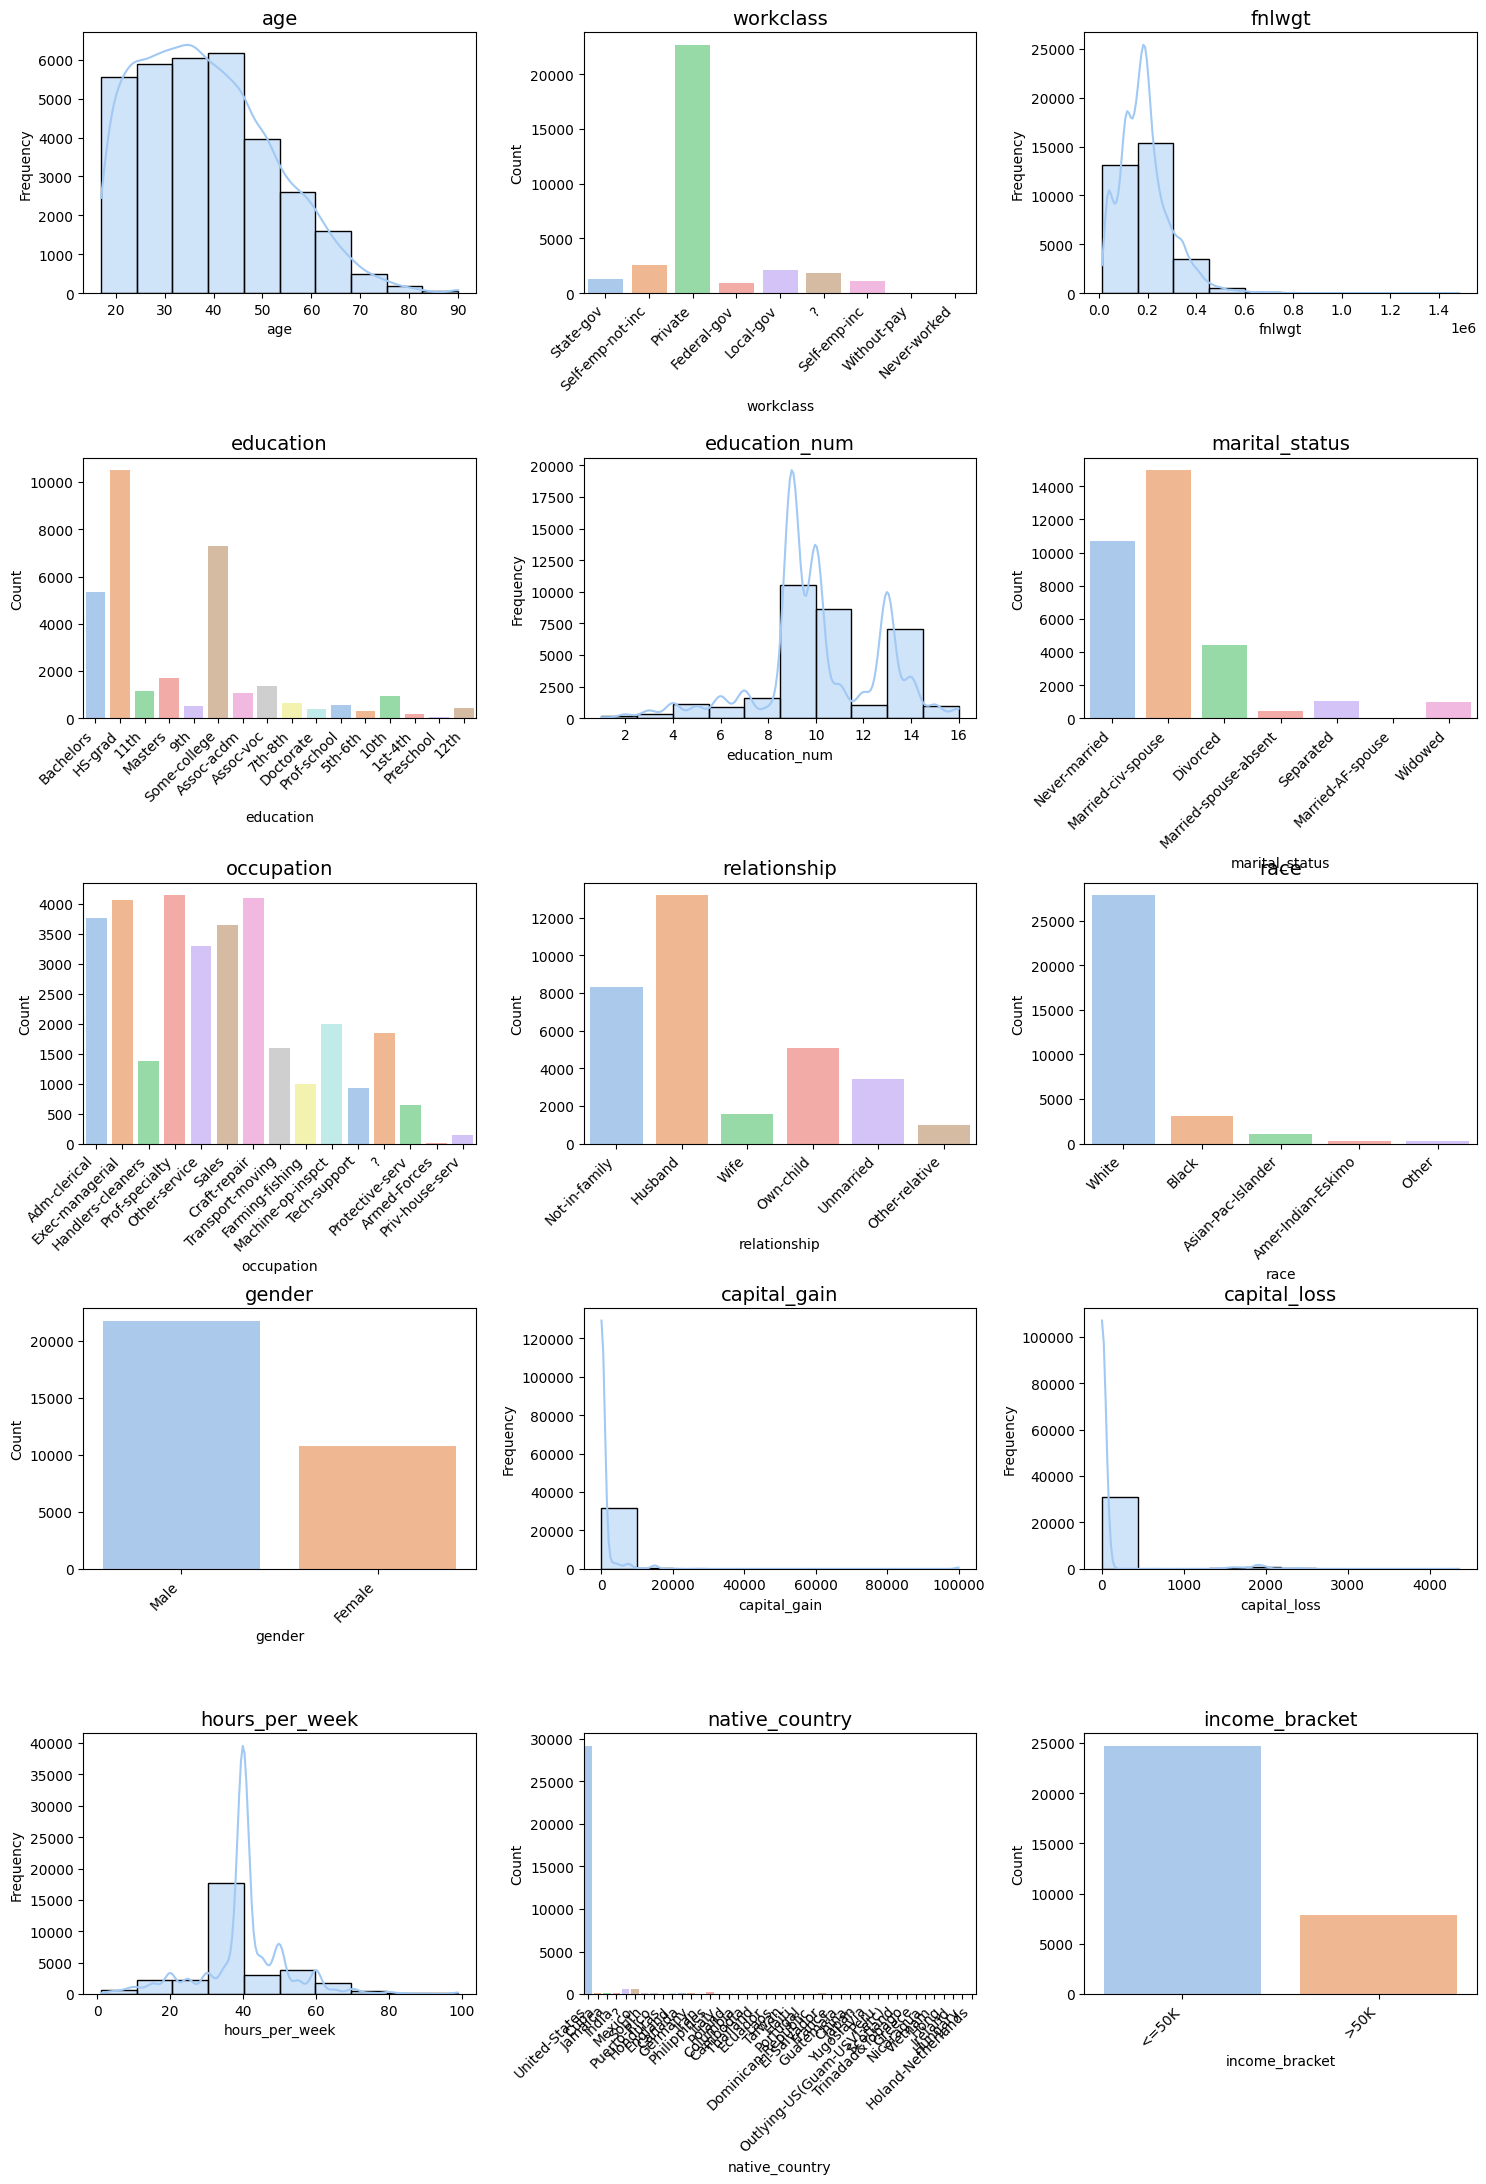

In [10]:
num_cols = 3
num_plots = len(df_train.columns)
num_rows = (num_plots + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()

for i, column in enumerate(df_train.columns):
    ax = axes[i]
    
    # Vérification du type de données
    if isinstance(df_train[column].dtype, pd.CategoricalDtype) or df_train[column].dtype == object:
        sns.countplot(x=column, hue=column, data=df_train, ax=ax, palette="pastel", legend=False)
        ax.set_ylabel("Count")
    
        ax.set_xticks(range(len(df_train[column].unique())))
        ax.set_xticklabels(df_train[column].unique(), rotation=45, ha='right')

    else:
        # Palette dynamique selon le nombre d'éléments uniques
        unique_vals = df_train[column].nunique()
        color = sns.color_palette("pastel", n_colors=unique_vals)
        
        sns.histplot(df_train[column], kde=True, bins=10, ax=ax, color=color[0])
        ax.set_ylabel("Frequency")
    
    ax.set_title(f"{column}", fontsize=14)

# Supprimer les sous-graphiques inutilisés
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()


##### Clean data

In [11]:
# Set label column
df_train['income_bracket'] = (df_train["income_bracket"].apply(lambda x: ">50K" in x)).astype(int)
df_test['income_bracket'] = (df_test["income_bracket"].apply(lambda x: ">50K" in x)).astype(int)

In [12]:
df_train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


## Attack / Defense

### Preprocess

In [13]:
scaler = MinMaxScaler()

def preprocess(df):

    # Split the DataFrame into features (x) and target variable (y)
    x = df.copy()
    x.drop('income_bracket', axis=1, inplace=True)
    y = df['income_bracket']

    # one-hot-encoding
    x = pd.get_dummies(x)

    # Scaling dataset
    x[x.columns] = scaler.fit_transform(x[x.columns])
    x.head()

    return x, y

### Preparing sets

##### Preparing the train set

In [14]:
x_train, y_train = preprocess(df_train)
x_train.head()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native_country_Portugal,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia
0,0.301370,0.044302,0.800000,0.02174,0.0,0.397959,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.452055,0.048238,0.800000,0.00000,0.0,0.122449,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.287671,0.138113,0.533333,0.00000,0.0,0.397959,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.493151,0.151068,0.400000,0.00000,0.0,0.397959,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.150685,0.221488,0.800000,0.00000,0.0,0.397959,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# Under sampling, to train the model on a balanced train set
sampler = RandomUnderSampler(random_state=5)
subxtrain, subytrain = sampler.fit_resample(x_train, y_train)
subxtrain, subytrain = shuffle(subxtrain, subytrain)
subxtrain.reset_index(drop=True, inplace=True)
subytrain.reset_index(drop=True, inplace=True)
subytrain.value_counts()

income_bracket
0    7841
1    7841
Name: count, dtype: int64

##### Preparing the test set

In [16]:
x_test, y_test = preprocess(df_test)

# Ensure test set has the same columns as the train set
x_test = x_test.reindex(columns=x_train.columns, fill_value=0)

x_test.head()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native_country_Portugal,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia
0,0.109589,0.144430,0.400000,0.000000,0.0,0.397959,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.287671,0.051677,0.533333,0.000000,0.0,0.500000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.150685,0.219011,0.733333,0.000000,0.0,0.397959,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.369863,0.099418,0.600000,0.076881,0.0,0.397959,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.013699,0.060942,0.600000,0.000000,0.0,0.295918,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [17]:
# Under sampling
sampler = RandomUnderSampler(random_state=5)
subxtest, subytest = sampler.fit_resample(x_test, y_test)
subxtest, subytest = shuffle(subxtrain, subytrain)
subxtest.reset_index(drop=True, inplace=True)
subytest.reset_index(drop=True, inplace=True)
subytest.value_counts()

income_bracket
1    7841
0    7841
Name: count, dtype: int64

### Define MLP

In [18]:
# Define the MLP model
mlp = Sequential([
        Input(shape=(subxtrain.shape[1],)),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

### Training

In [19]:
# Compilation and training
mlp.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
mlp.fit(subxtrain, subytrain, epochs=100, batch_size=32, verbose=0)

In [20]:
# Evaluate the model
yhat_train = (mlp.predict(subxtrain) >= 0.5).astype(int).ravel()
print("MLP Training Accuracy on train set :", accuracy_score(subytrain, yhat_train))

491/491 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MLP Training Accuracy on train set : 0.9311950006376738


### Classification Performance

In [21]:
yhat = (mlp.predict(subxtest) >= 0.5).astype(int).ravel()
print(classification_report(np.array(subytest), yhat, target_names=['<=50K', '>50K']))

491/491 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
              precision    recall  f1-score   support

       <=50K       0.95      0.91      0.93      7841
        >50K       0.92      0.95      0.93      7841

    accuracy                           0.93     15682
   macro avg       0.93      0.93      0.93     15682
weighted avg       0.93      0.93      0.93     15682



## Attack

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

First, the test sets (`subxtest` and `subytest`) are converted into NumPy arrays for better compatibility with adversarial attack methods :
</div>

In [22]:
X_test = subxtest.to_numpy()
Y_test = subytest.to_numpy()

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
A TensorFlow-based classifier is instantiated using the Adversarial Robustness Toolbox (ART) to encapsulate the MLP model. This wrapper makes the model compatible with adversarial attack techniques :
</div>

In [23]:
classifier = TensorFlowV2Classifier(
    model=mlp,
    nb_classes=2,  # Number of classes
    input_shape=subxtest.shape[1:],  # Shape of input data
    loss_object=tf.keras.losses.BinaryCrossentropy(from_logits=False),  # Loss function
    clip_values=(0.0, 1.0)  # Min and max values for the data
)

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
Before introducing adversarial perturbations, the model's accuracy is tested on clean test samples. This serves as a baseline to compare the model's performance before and after adversarial attacks. Here, we take the first 1,000 test samples and count how many are correctly classified :
</div>

In [24]:
x_test_pred = (classifier.predict(X_test[:1000]) >= 0.5).astype(int).ravel()
nb_correct_pred = np.sum(x_test_pred == Y_test[:1000])

print("Adversarial test data :")
print("Correctly classified: {}".format(nb_correct_pred))
print("Incorrectly classified: {}".format(1000-nb_correct_pred))

Adversarial test data :
Correctly classified: 922
Incorrectly classified: 78


##### Fast Gradient Descent

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
The Fast Gradient Method (FGM) is a simple yet effective attack that perturbs input data along the gradient of the model’s loss function. The idea is to find the smallest modification that can mislead the classifier.
</div>

In [44]:
attacker = FastGradientMethod(classifier, eps=0.2)
x_test_adv = attacker.generate(X_test[:1000])

In [45]:
x_test_adv_pred = (classifier.predict(x_test_adv) >= 0.5).astype(int).ravel()
nb_correct_adv_pred = np.sum(x_test_adv_pred == Y_test[:1000])

print("Adversarial test data (FGM) :")
print("Correctly classified: {}".format(nb_correct_adv_pred))
print("Incorrectly classified: {}".format(1000-nb_correct_adv_pred))

Adversarial test data (FGM) :
Correctly classified: 550
Incorrectly classified: 450


<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
To find the best epsilon (eps) value for the Fast Gradient Method (FGM) attack, we can evaluate the model's accuracy over a range of epsilon values. The goal is to identify the smallest eps that significantly degrades model performance while keeping perturbations minimal.
</div>

Epsilon: 0.01 - Accuracy: 0.8590
Epsilon: 0.06 - Accuracy: 0.6660
Epsilon: 0.12 - Accuracy: 0.5930
Epsilon: 0.17 - Accuracy: 0.5570
Epsilon: 0.23 - Accuracy: 0.5420
Epsilon: 0.28 - Accuracy: 0.5370
Epsilon: 0.34 - Accuracy: 0.5320
Epsilon: 0.39 - Accuracy: 0.5300
Epsilon: 0.45 - Accuracy: 0.5290
Epsilon: 0.50 - Accuracy: 0.5270


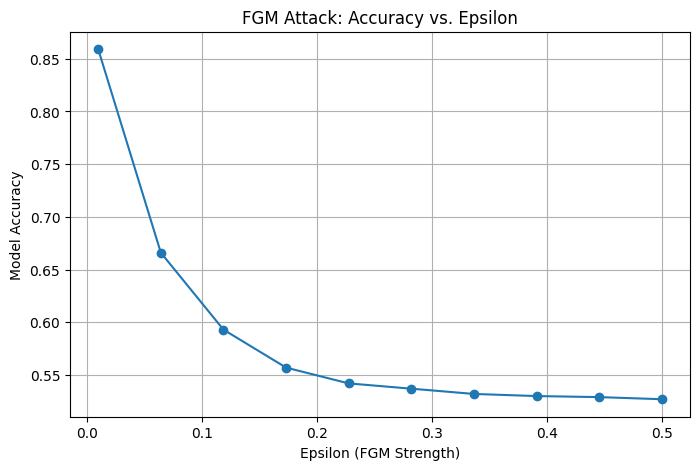

In [31]:
# We define a range of epsilon values
epsilons = np.linspace(0.01, 0.5, 10)
accuracies = []

for eps in epsilons:
    attacker = FastGradientMethod(classifier, eps=eps)
    x_test_adv = attacker.generate(X_test[:1000])
    
    y_test_adv_pred = (classifier.predict(x_test_adv) >= 0.5).astype(int).ravel()
    
    # Compute accuracy
    acc = accuracy_score(Y_test[:1000], y_test_adv_pred)
    accuracies.append(acc)
    print(f"Epsilon: {eps:.2f} - Accuracy: {acc:.4f}")

# Plot the accuracy vs epsilon graph
plt.figure(figsize=(8, 5))
plt.plot(epsilons, accuracies, marker='o', linestyle='-')
plt.xlabel("Epsilon (FGM Strength)")
plt.ylabel("Model Accuracy")
plt.title("FGM Attack: Accuracy vs. Epsilon")
plt.grid()
plt.show()


<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

From the graph, we observe that as epsilon (FGM perturbation strength) increases, model accuracy decreases significantly.
The model's accuracy drops sharply from ~85% to ~65% when $\epsilon$ increases from $0.01$ to $0.06$. This suggests that even small perturbations can cause significant misclassification. Then, accuracy continues to decline but at a slower rate, reaching ~55% around $\epsilon = 0.17$. After $\epsilon = 0.28$, the accuracy stabilizes around ~53%, indicating that increasing epsilon further does not cause significantly more misclassification. This suggests the attack reaches a saturation point where additional noise does not further degrade performance. 

A good choice of $\epsilon$ is around $0.1$ to $0.2$, as this range maximizes impact while keeping perturbations minimal.
</div>

##### Projected Gradient Descent

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
The Projected Gradient Descent (PGD) attack is a more powerful, iterative variant of FGM. Instead of making a single-step perturbation, PGD applies multiple small perturbations while ensuring the modified samples stay within a given constraint.
</div>

In [32]:
attacker = ProjectedGradientDescent(classifier, norm = "inf", eps=0.2)
x_test_adv = attacker.generate(X_test[:1000])

In [33]:
x_test_adv_pred = np.argmax(classifier.predict(x_test_adv), axis=1)
nb_correct_adv_pred = np.sum(x_test_adv_pred == Y_test[:1000])

print("Adversarial test data (PGD) :")
print("Correctly classified: {}".format(nb_correct_adv_pred))
print("Incorrectly classified: {}".format(1000-nb_correct_adv_pred))

Adversarial test data (PGD) :
Correctly classified: 478
Incorrectly classified: 522


<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
PGD is more effective than FGM at fooling the model, with a higher misclassification rate. FGM remains a strong attack, but since it is a single-step attack, it is often less effective than PGD, which iteratively refines the adversarial perturbation. PGD is more robust, as it explores the attack space more thoroughly, leading to a higher number of misclassified examples.
</div>

## Defense